# Apache Sedona Tutorial - Spatial Join

---

### Process
1. Initialise a Spark session with Sedona enabled
2. Load boundary and point datasets
3. Convert them to geospatial DataFrames
4. Perform a point in polygon spatial join
5. Map the points, coloured by boundary ID

---

In [1]:
# fix autocomplete issue
%config Completer.use_jedi = False

In [2]:
# import Python packages

import os

from multiprocessing import cpu_count

from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer

In [3]:
# set input path for parquet files
input_path = os.path.join(os.getcwd(), "../data")

# set max number of processes (defaults to 2x physical CPUs)
num_processors = cpu_count() * 2

### Create the Spark session

In [4]:

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("query") \
    .config("spark.sql.session.timeZone", "UTC") \
    .config("spark.sql.debug.maxToStringFields", 100) \
    .config("spark.serializer", KryoSerializer.getName) \
    .config("spark.kryo.registrator", SedonaKryoRegistrator.getName) \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.executor.cores", 1) \
    .config("spark.cores.max", num_processors) \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "1g") \
    .getOrCreate()

print("Spark {} session initialised".format(spark.version))

Spark 3.0.1 session initialised


Register Sedona's User Defined Types (UDTs) and Functions (UDFs) with the Spark session

In [5]:
SedonaRegistrator.registerAll(spark)

True

### Load dataframes

#### 1. Load boundary data from gzipped parquet files

Boundary geometries are polygons stored as OGC Well Known Text (WKT) strings.

In [6]:
bdy_wkt_df = spark.read.parquet(os.path.join(input_path, "boundaries"))
bdy_wkt_df.printSchema()
bdy_wkt_df.show(5)

print("Loaded {} records".format(bdy_wkt_df.count()))

root
 |-- bdy_id: string (nullable = true)
 |-- bdy_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- wkt_geom: string (nullable = true)

+------+--------------------+---------------+--------------------+
|bdy_id|            bdy_type|          state|            wkt_geom|
+------+--------------------+---------------+--------------------+
|  RA10|Major Cities of A...|New South Wales|POLYGON((149.1082...|
|  RA10|Major Cities of A...|New South Wales|POLYGON((149.1914...|
|  RA10|Major Cities of A...|New South Wales|POLYGON((149.1914...|
|  RA10|Major Cities of A...|New South Wales|POLYGON((149.1914...|
|  RA10|Major Cities of A...|New South Wales|POLYGON((149.2007...|
+------+--------------------+---------------+--------------------+
only showing top 5 rows

Loaded 17540 records


In [7]:
# Create a view of the DataFrame to enable SQL queries
bdy_wkt_df.createOrReplaceTempView("bdy_wkt")

#### 2. Load point data

Spatial data is stored in latitude & longitude (double precision) fields

In [8]:
point_wkt_df = spark.read.parquet(os.path.join(input_path, "points"))
point_wkt_df.printSchema()
point_wkt_df.show(5, False)

print("Loaded {} records".format(point_wkt_df.count()))

# create view to enable SQL queries
point_wkt_df.createOrReplaceTempView("point_wkt")

root
 |-- point_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)

+-----------+---------------+-------------------+------------------+
|point_id   |state          |latitude           |longitude         |
+-----------+---------------+-------------------+------------------+
|10000063000|New South Wales|-36.077980986803816|146.94716696685703|
|10000152000|New South Wales|-36.04300542630207 |146.910526433595  |
|10000200000|New South Wales|-36.05157619854574 |146.91949219941486|
|10000310000|New South Wales|-36.070499212173615|146.8918609267459 |
|10000393000|New South Wales|-35.939528641039175|147.01725670789446|
+-----------+---------------+-------------------+------------------+
only showing top 5 rows

Loaded 35800 records


### Create geospatial dataframes

#### 1. Create boundary geometries from WKT strings

In [9]:
bdy_df = spark.sql("select bdy_id, bdy_type, state, st_geomFromWKT(wkt_geom) as geom from bdy_wkt")
#     .repartition("state")
bdy_df.printSchema()
bdy_df.show(5)

# create view to enable SQL queries
bdy_df.createOrReplaceTempView("bdy")

root
 |-- bdy_id: string (nullable = true)
 |-- bdy_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- geom: geometry (nullable = false)

+------+--------------------+---------------+--------------------+
|bdy_id|            bdy_type|          state|                geom|
+------+--------------------+---------------+--------------------+
|  RA10|Major Cities of A...|New South Wales|POLYGON ((149.108...|
|  RA10|Major Cities of A...|New South Wales|POLYGON ((149.191...|
|  RA10|Major Cities of A...|New South Wales|POLYGON ((149.191...|
|  RA10|Major Cities of A...|New South Wales|POLYGON ((149.191...|
|  RA10|Major Cities of A...|New South Wales|POLYGON ((149.200...|
+------+--------------------+---------------+--------------------+
only showing top 5 rows



#### 2. Create point geometries. from lat/long fields

In [10]:
point_df = spark.sql("select point_id, state, st_point(longitude, latitude) as geom from point_wkt")
#     .repartition("state")
point_df.printSchema()
point_df.show(5, False)

# create view to enable SQL queries
point_df.createOrReplaceTempView("pnt")

root
 |-- point_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- geom: geometry (nullable = false)

+-----------+---------------+----------------------------------------------+
|point_id   |state          |geom                                          |
+-----------+---------------+----------------------------------------------+
|10000063000|New South Wales|POINT (146.94716696685703 -36.077980986803816)|
|10000152000|New South Wales|POINT (146.910526433595 -36.04300542630207)   |
|10000200000|New South Wales|POINT (146.91949219941486 -36.05157619854574) |
|10000310000|New South Wales|POINT (146.8918609267459 -36.070499212173615) |
|10000393000|New South Wales|POINT (147.01725670789446 -35.939528641039175)|
+-----------+---------------+----------------------------------------------+
only showing top 5 rows



### Run a spatial join to boundary tag the points

##### Note:
1. One of the dataframes will be spatially indexed automatically to speed up the query
2. It's an inner join; point records could be lost in coastal areas or where there are gaps in the boundaries

In [11]:
from datetime import datetime

start_time = datetime.now()

sql = """SELECT pnt.point_id,
                bdy.bdy_id,
                bdy.bdy_type,
                bdy.state,
                pnt.geom
         FROM pnt
         INNER JOIN bdy ON ST_Intersects(pnt.geom, bdy.geom)"""
join_df = spark.sql(sql).cache()

join_df.printSchema()
join_df.show(5, False)

join_count = join_df.count()

print("Boundary tagged {} points".format(join_count))
print("Retrieved top 5 rows in {}".format(datetime.now() - start_time))

root
 |-- point_id: string (nullable = true)
 |-- bdy_id: string (nullable = true)
 |-- bdy_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- geom: geometry (nullable = false)

+-----------+------+------------------------+---------------+----------------------------------------------+
|point_id   |bdy_id|bdy_type                |state          |geom                                          |
+-----------+------+------------------------+---------------+----------------------------------------------+
|10000063000|RA11  |Inner Regional Australia|New South Wales|POINT (146.94716696685703 -36.077980986803816)|
|10000152000|RA11  |Inner Regional Australia|New South Wales|POINT (146.910526433595 -36.04300542630207)   |
|10000200000|RA11  |Inner Regional Australia|New South Wales|POINT (146.91949219941486 -36.05157619854574) |
|10000310000|RA11  |Inner Regional Australia|New South Wales|POINT (146.8918609267459 -36.070499212173615) |
|10000393000|RA11  |Inner Regional Au

### Export results to Geopandas

In [14]:
import geopandas

pandas_df = join_df.toPandas()
geopandas_df = geopandas.GeoDataFrame(pandas_df, geometry="geom")

### Map the result

(93.28457078771922, 171.54515682162742, -45.35782065915447, -7.546822673916637)

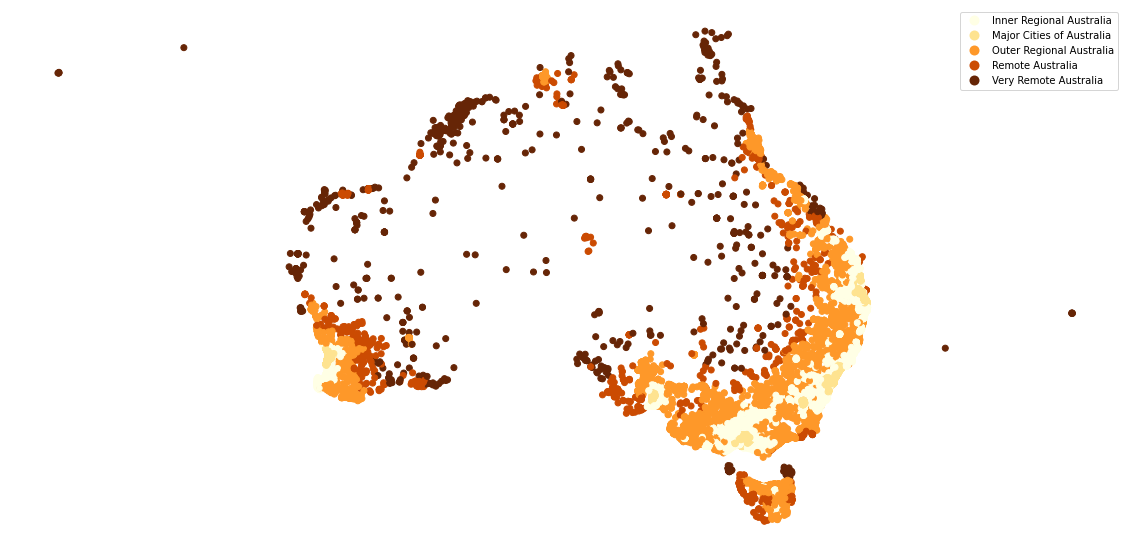

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(20, 20))

geopandas_df.plot(
    column="bdy_type",
    legend=True,
    cmap='YlOrBr',
    ax=ax
)

ax.axis('off')


### Close the Spark session

In [12]:
spark.stop()